In [1]:
from baccus import BACCUS
import numpy as np
from numpy.random import normal
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Generate data

In [2]:
#2d gaussian: 
mean = [0., 0.]
cov = [[0.25, 0.02], [0.02, 0.04]]  # diagonal covariance
x1, y1 = np.random.multivariate_normal(mean, cov, 500).T
sx1 = np.ones(500)*0.3
sy1 = np.ones(500)*0.2

In [3]:
#2d gaussian: 
mean = [-1., 1]
cov = [[0.04, -0.005], [-0.005, 0.01]]  # diagonal covariance
x2, y2 = np.random.multivariate_normal(mean, cov, 200).T
sx2 = np.ones(200)*0.2
sy2 = np.ones(200)*0.05

In [4]:
#2d gaussian: 
mean = [2., -2]
cov = [[0.04, -0.005], [-0.005, 0.01]]  # diagonal covariance
x3, y3 = np.random.multivariate_normal(mean, cov, 300).T
sx3 = np.ones(300)*0.02
sy3 = np.ones(300)*0.05

In [5]:
data1 = np.stack((x1,y1,sx1,sy1),axis=1)
data2 = np.stack((x2,y2,sx2,sy2),axis=1)
data3 = np.stack((x3,y3,sx3,sy3),axis=1)
DATA = [data1,data2,data3]

#### Plot data

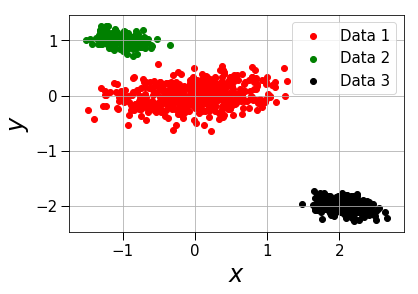

In [6]:
plt.scatter(x1,y1,color='r',label='Data 1')
plt.scatter(x2,y2,color='g',label='Data 2')
plt.scatter(x3,y3,color='k',label='Data 3')

plt.legend(fontsize=15)
plt.xlabel(r'$x$',fontsize=24)
plt.ylabel(r'$y$',fontsize=24)
plt.tick_params(axis='both',width=1,length=8,labelsize=15)
plt.grid()
plt.show()

## Define lkl function

In [7]:
def lkl_norescale(theta,DATA):
    x = theta[0]
    y = theta[1]
    
    count = 0
    npar = 2
    
    log_lkl = 0
    for i in range(0,len(DATA)):
        shift_x = theta[npar+count]
        count += 1
        shift_y = theta[npar+count]
        count += 1
        
        xpar = x+shift_x
        ypar = y+shift_y

        dat = DATA[i]
        xdat = dat[:,0]
        ydat = dat[:,1]
        sx = dat[:,2]
        sy = dat[:,3]
        
        log_lkl -= 0.5*(np.sum(((xdat-xpar)/sx)**2.) + np.sum(((ydat-ypar)/sy)**2.))
        
    return log_lkl
    

## Prepare to call BACCUS

In [31]:
#bounds for the priors of the model parameters
prior_bounds_model = [(-10.,10.),(-10.,10.)]
#bounds for the priors of the shifts
prior_bounds_shifts = [(0,-8.,8.),(1,-8.,8.)]
#bounds for the priors of the variances of the shifts
prior_bounds_var = [(0,0,8),(1,0,8)]
#which shifts in each data set
kind_shifts = [(0,1),(0,1),(0,1)]
#prior for the variances of the shifts - a lognormal
b = -2
xi = 10
y = T.dscalar('y')
s = -0.5*((T.log(y)-b)/2./xi)**2.
logprior_sigma2 = theano.function([y],s)
prior_var = []
for ivar in range(0,2):
    prior_var += [logprior_sigma2]

#### Plot prior on variances of the shifts

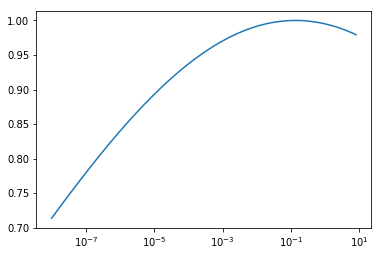

In [32]:
xx = np.logspace(-8,np.log10(8),1000)
logp = np.zeros(len(xx))

for i in range(0,len(xx)):
    logp[i] = np.exp(logprior_sigma2(xx[i]))
    
plt.semilogx(xx,logp)
plt.show()

In [33]:
want_rescaling = False
model = BACCUS(prior_bounds_model=prior_bounds_model,prior_bounds_shifts=prior_bounds_shifts,prior_bounds_var=prior_bounds_var,
              lkl = lkl_norescale, kind_shifts = kind_shifts,prior_var=prior_var,want_rescaling=want_rescaling)

In [34]:
#Set initial position, steps and walkers
nwalkers = 250
steps = 4000
ndata = len(DATA)
pos = []

for i in range(0,nwalkers):
    #Model parameters
    pos += [np.array([normal(0,1),normal(0,1)])]
    #Rescaling parameters, if wanted
    if want_rescaling:
        for j in range(0,ndata):
            pos[i] = np.append(pos[i],normal(1,0.2))
    #shift_hyperparams
    for j in range(0,ndata):
        pos[i] = np.append(pos[i],normal(0.,1.))
        pos[i] = np.append(pos[i],normal(0.,1.))
                
    #var for shifts
    pos[i] = np.append(pos[i],normal(1.,0.2))
    pos[i] = np.append(pos[i],normal(1.,0.2))
        
    #correlation of shifts
    pos[i] = np.append(pos[i],normal(0.,0.2))


## RUN the CHAIN

In [35]:
model.run_chain(DATA, stepsize=2., pos=pos, nwalkers=nwalkers, steps=steps)

Total steps =  1000000
Running MCMC...
Done.


## Get the Results


Chain with 250 walkers and 4000 steps: Total steps = 1000000

bestfit =  [ 0.91151885 -0.90376995 -0.90181832  0.91371762 -1.90265533  1.90220236
  1.12761152 -1.09422917  2.22406667  2.21956539 -0.9999008 ]

with **unnormalized** min -logLkl =  18492.763821847722

Mean acceptance fraction = 0.294585


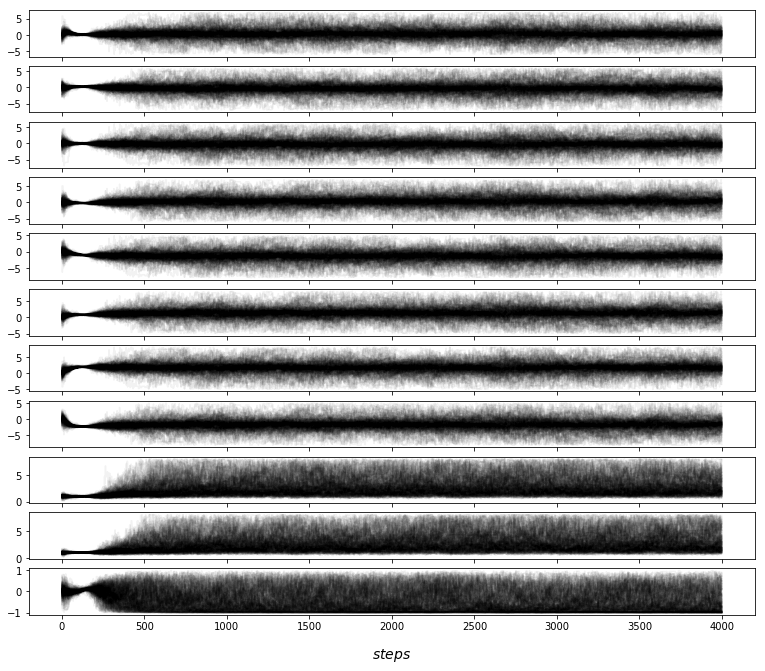

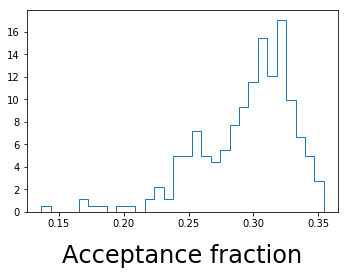

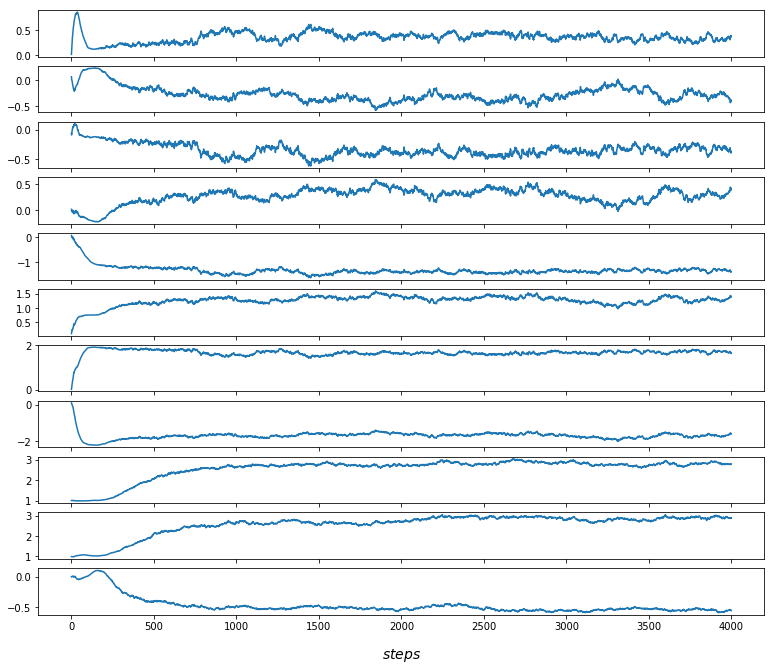

In [36]:
model.get_results(want_plots=True)

In [37]:
import emcee
print emcee.__version__

2.1.0


## PLOT RESULTS

In [38]:
chain = np.loadtxt('output_chain.txt')

In [39]:
columns = chain.shape[1]

steps=steps
nwalkers=nwalkers
burn_len = int(0.3*steps)

chain_burned = np.zeros([(steps - burn_len)*nwalkers, columns])
for i in range (0,nwalkers):
    slic = i*steps
    walk = chain[(i*steps + burn_len):((i+1)*steps),:]
    chain_burned[(i*(steps-burn_len)):((i+1)*(steps-burn_len)), :] = walk

In [40]:
def convert_to_varev(logL):
    """
    Given a grid of log-likelihood values, convert them to cumulative
    standard deviation.  This is useful for drawing contours from a
    grid of likelihoods.
    """
    sigma = np.exp(logL)

    shape = sigma.shape
    sigma = sigma.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(sigma)[::-1]
    i_unsort = np.argsort(i_sort)

    sigma_cumsum = sigma[i_sort].cumsum()
    sigma_cumsum /= sigma_cumsum[-1]

    return sigma_cumsum[i_unsort].reshape(shape)

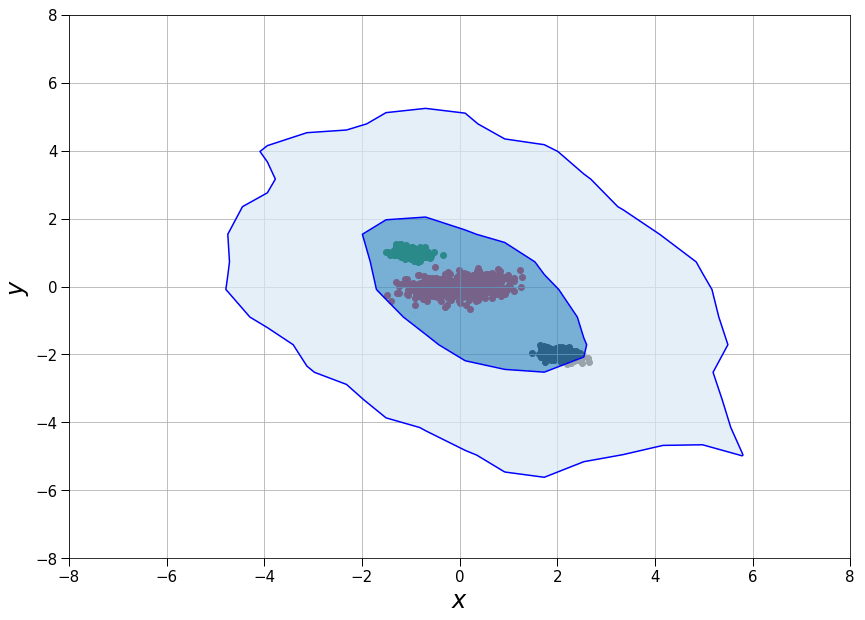

In [50]:
H,x, y = np.histogram2d(chain_burned[:,1],chain_burned[:,2],bins=(16,16),weights=np.ones(len(chain_burned[:,0])),normed=True)
x22 = 0.5*(x[1:]+x[:-1])
y22 = 0.5*(y[1:]+y[:-1])
H[H==0] = 1e-16
H = convert_to_varev(np.log(H))
    
f, axarr = plt.subplots(nrows=1,ncols=1, figsize=(14,10))
axarr.contourf(x22,y22,H.T,zorder = 2,levels=[0.,0.683,0.954],cmap=plt.cm.Blues_r,alpha=0.7)
axarr.contour(x22,y22,H.T,levels=[0.,0.683,0.954],colors='b',linewidth = 2.,zorder=2)
axarr.scatter(x1,y1,color='r')
axarr.scatter(x2,y2,color='g')
axarr.scatter(x3,y3,color='k')


axarr.tick_params(axis='both',width=1,length=8,labelsize=15)
axarr.set_xlabel(r'$x$',fontsize=24)
axarr.set_ylabel(r'$y$',fontsize=24)
axarr.set_xlim(-8,8)
axarr.set_ylim(-8,8)
axarr.grid()

plt.show()

## Likelihood with rescaling

In [42]:
def lkl_rescale(theta,DATA):
    x = theta[0]
    y = theta[1]
    
    nrescaling = len(DATA)
    count = 0
    npar = 2
    
    log_lkl = 0
    for i in range(0,len(DATA)):
        alpha = theta[npar+i]
        shift_x = theta[npar+nrescaling+count]
        count += 1
        shift_y = theta[npar+nrescaling+count]
        count += 1
        
        xpar = x+shift_x
        ypar = y+shift_y

        dat = DATA[i]
        xdat = dat[:,0]
        ydat = dat[:,1]
        sx = dat[:,2]
        sy = dat[:,3]
        
        log_lkl -= 0.5*alpha*(np.sum(((xdat-xpar)/sx)**2.) + np.sum(((ydat-ypar)/sy)**2.))
        
    return log_lkl
    

#### Redo the same with rescaling

In [43]:
want_rescaling = True
model_res = BACCUS(prior_bounds_model=prior_bounds_model,prior_bounds_shifts=prior_bounds_shifts,prior_bounds_var=prior_bounds_var,
              lkl = lkl_rescale, kind_shifts = kind_shifts,prior_var=prior_var,want_rescaling=want_rescaling)

In [44]:
#Set initial position, steps and walkers
nwalkers = 200
steps = 3000
ndata = len(DATA)
pos = []

for i in range(0,nwalkers):
    #Model parameters
    pos += [np.array([normal(0,1),normal(0,1)])]
    #Rescaling parameters, if wanted
    if want_rescaling:
        for j in range(0,ndata):
            pos[i] = np.append(pos[i],normal(1,0.2))
    #shift_hyperparams
    for j in range(0,ndata):
        pos[i] = np.append(pos[i],normal(0.,1.))
        pos[i] = np.append(pos[i],normal(0.,1.))
                
    #var for shifts
    pos[i] = np.append(pos[i],normal(1.,0.2))
    pos[i] = np.append(pos[i],normal(1.,0.2))
        
    #correlation of shifts
    pos[i] = np.append(pos[i],normal(0.,0.2))


In [45]:
model_res.run_chain(DATA, stepsize=2., pos=pos, nwalkers=nwalkers, steps=steps)

Total steps =  600000
Running MCMC...
Done.


In [46]:
model_res.get_results(root='output_rs_')


Chain with 200 walkers and 3000 steps: Total steps = 600000

bestfit =  [ 0.21124712 -0.20522766  0.24614822  0.20116755  0.00856496 -0.23305314
  0.20196242 -1.23086692  1.2005134   1.83396377 -1.78567003  1.24444232
  1.2251393  -0.99925818]

with **unnormalized** min -logLkl =  1710.5994951338357

Mean acceptance fraction = 0.273637


In [47]:
chain_rs = np.loadtxt('output_rs_chain.txt')


In [48]:
columns = chain_rs.shape[1]

steps=steps
nwalkers=nwalkers
burn_len = int(0.3*steps)

chain_rs_burned = np.zeros([(steps - burn_len)*nwalkers, columns])
for i in range (0,nwalkers):
    slic = i*steps
    walk = chain_rs[(i*steps + burn_len):((i+1)*steps),:]
    chain_rs_burned[(i*(steps-burn_len)):((i+1)*(steps-burn_len)), :] = walk

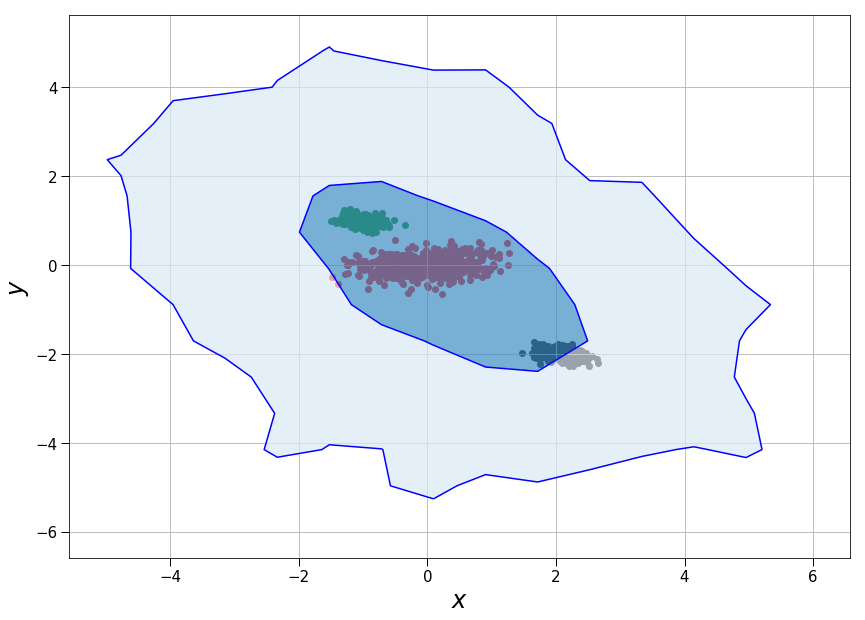

In [51]:
H,x, y = np.histogram2d(chain_rs_burned[:,1],chain_rs_burned[:,2],bins=(16,16),weights=np.ones(len(chain_rs_burned[:,0])),normed=True)
x22 = 0.5*(x[1:]+x[:-1])
y22 = 0.5*(y[1:]+y[:-1])
H[H==0] = 1e-16
H = convert_to_varev(np.log(H))
    
f, axarr = plt.subplots(nrows=1,ncols=1, figsize=(14,10))
axarr.contourf(x22,y22,H.T,zorder = 2,levels=[0.,0.683,0.954],cmap=plt.cm.Blues_r,alpha=0.7)
axarr.contour(x22,y22,H.T,levels=[0.,0.683,0.954],colors='b',linewidth = 2.,zorder=2)
axarr.scatter(x1,y1,color='r')
axarr.scatter(x2,y2,color='g')
axarr.scatter(x3,y3,color='k')


axarr.tick_params(axis='both',width=1,length=8,labelsize=15)
axarr.set_xlabel(r'$x$',fontsize=24)
axarr.set_ylabel(r'$y$',fontsize=24)
#axarr.set_xlim(0.5,1.3)
#axarr.set_ylim(0.3,1.3)
axarr.grid()

plt.show()